# Progetto: Analisi di Wikipedia

## Descrizione del progetto
Wikidata Insights, un'azienda leader nella gestione di contenuti digitali, è stata incaricata da Wikimedia per ottimizzare l'analisi e la categorizzazione dei contenuti di Wikipedia. Per supportare la loro continua espansione e migliorare l'organizzazione delle informazioni, Wikidata Insights ha deciso di condurre un progetto avanzato di data analysis e machine learning. L'obiettivo principale è comprendere meglio il vasto patrimonio di contenuti informativi offerti da Wikipedia e sviluppare un sistema di classificazione automatica che consenta di categorizzare efficacemente i nuovi articoli futuri.

## Importazione del dataset e delle librerie

In [0]:
!wget -O /databricks/driver/wikipedia.csv https://proai-datasets.s3.eu-west-3.amazonaws.com/wikipedia.csv

--2025-01-05 10:12:26--  https://proai-datasets.s3.eu-west-3.amazonaws.com/wikipedia.csv
Resolving proai-datasets.s3.eu-west-3.amazonaws.com (proai-datasets.s3.eu-west-3.amazonaws.com)... 16.12.20.46, 16.12.19.22
Connecting to proai-datasets.s3.eu-west-3.amazonaws.com (proai-datasets.s3.eu-west-3.amazonaws.com)|16.12.20.46|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1003477941 (957M) [text/csv]
Saving to: ‘/databricks/driver/wikipedia.csv’

/databricks/driver/ 100%[===================>] 956.99M  20.7MB/s    in 47s     

2025-01-05 10:13:14 (20.3 MB/s) - ‘/databricks/driver/wikipedia.csv’ saved [1003477941/1003477941]



In [0]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.functions import count, when, isnan, col, avg, round, max, min, udf, explode, sum as spark_sum, size, lit
import pyspark.sql.functions as F
from pyspark.sql.window import Window
from pyspark.sql.types import Row, ArrayType, StringType
from pyspark.ml import Transformer, Pipeline
from pyspark.ml.feature import Tokenizer, StopWordsRemover, StringIndexer, CountVectorizer
from pyspark.ml.param.shared import Param, Params
from pyspark.ml.classification import LogisticRegression, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [0]:
dataset = pd.read_csv('/databricks/driver/wikipedia.csv')
dataset.head()

Unnamed: 0  ...  categoria
0           0  ...  economics
1           1  ...  economics
2           2  ...  economics
3           3  ...  economics
4           4  ...  economics

[5 rows x 5 columns]

In [0]:
spark = SparkSession.builder.appName('wikipedia-analysis').getOrCreate()

In [0]:
#conversione in un dataframe spark
df = spark.createDataFrame(dataset)
df = df.drop("Unnamed: 0")
df.show()

+--------------------+--------------------+--------------------+---------+
|               title|             summary|           documents|categoria|
+--------------------+--------------------+--------------------+---------+
|           economics|economics () is a...|economics () is a...|economics|
|index of economic...|this aims to be a...|this aims to be a...|economics|
|     cryptoeconomics|cryptoeconomics i...|cryptoeconomics i...|economics|
|economic impact a...|an economic impac...|an economic impac...|economics|
|      economic trend|economic trend ma...|economic trend ma...|economics|
|    entrepreneurship|entrepreneurship ...|entrepreneurship ...|economics|
|    factor investing|factor investing ...|factor investing ...|economics|
|          filtering |in housing econom...|in housing econom...|economics|
|          free trade|free trade is a t...|free trade is a t...|economics|
|         liquidation|liquidation is th...|liquidation is th...|economics|
|       profit motive|in 

## EDA - Exploration Data Analysis

Di seguito si riporta la fase di analisi esplorativa del dataset, volta ad individuarne delle caratteristiche utili a definire le migliori fasi di pre-processing e le migliori procedure di addestramento dei modelli, per conseguire gli obiettivi dell'analisi.

Per prima cosa si effettua un controllo circa la presenza di valori NaN o Null all'interno del dataset.

In [0]:
#ricerca per ciascuna colonna del dataset i valori NaN
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).show()

+-----+-------+---------+---------+
|title|summary|documents|categoria|
+-----+-------+---------+---------+
|    0|      0|        0|        0|
+-----+-------+---------+---------+



In [0]:
#ricerca per ciascuna colonna del dataset i valori Null
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+-----+-------+---------+---------+
|title|summary|documents|categoria|
+-----+-------+---------+---------+
|    0|    928|      928|        0|
+-----+-------+---------+---------+



Quindi non sono presenti articoli con valori NaN, ma sono presenti diversi articoli che presentano valori nulli per summary e documents. Poiché per i task progettuali richiesti, questi sono proprio i campi su cui sarà necessario addestrare il classificatore automatico, si può procedere all'eliminazione di tali record che non portano altre informazioni significative per l'analisi.

In [0]:
#eliminazione degli articoli vuoti
df_cleaned = df.filter(col("documents").isNotNull() & (col('documents')!=""))
df_cleaned.show()

+--------------------+--------------------+--------------------+---------+
|               title|             summary|           documents|categoria|
+--------------------+--------------------+--------------------+---------+
|           economics|economics () is a...|economics () is a...|economics|
|index of economic...|this aims to be a...|this aims to be a...|economics|
|     cryptoeconomics|cryptoeconomics i...|cryptoeconomics i...|economics|
|economic impact a...|an economic impac...|an economic impac...|economics|
|      economic trend|economic trend ma...|economic trend ma...|economics|
|    entrepreneurship|entrepreneurship ...|entrepreneurship ...|economics|
|    factor investing|factor investing ...|factor investing ...|economics|
|          filtering |in housing econom...|in housing econom...|economics|
|          free trade|free trade is a t...|free trade is a t...|economics|
|         liquidation|liquidation is th...|liquidation is th...|economics|
|       profit motive|in 

In [0]:
#verifica dell'effettiva eliminazione dei valori Null
df_cleaned.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+-----+-------+---------+---------+
|title|summary|documents|categoria|
+-----+-------+---------+---------+
|    0|      0|        0|        0|
+-----+-------+---------+---------+



In [0]:
#si salva il dataset in una tabella spark
df_cleaned.write.mode("overwrite").saveAsTable('wikipedia')

Si definiscono alcune caratteristiche del dataset, come il numero complessivo degli articoli e il numero di categorie in cui essi sono suddivisi.

In [0]:
n_articles = df_cleaned.count()
print(f"Il dataset contiene: {n_articles} articoli")

Il dataset contiene: 152304 articoli


In [0]:
n_categories = df_cleaned.select('categoria').distinct().count()
print(f"Gli articoli del dataset sono suddivisi in {n_categories} categorie")

Gli articoli del dataset sono suddivisi in 15 categorie


Si mostrano anche le categorie.

In [0]:
df_categories = df_cleaned.select('categoria').distinct()
df_categories.show()

+-----------+
|  categoria|
+-----------+
|  economics|
|   politics|
|    culture|
|    science|
|     sports|
|     energy|
|    finance|
| humanities|
|       pets|
|      trade|
| technology|
|  transport|
|   medicine|
|engineering|
|   research|
+-----------+



### EDA: Conteggio Articoli per categoria
Si procede a definire il numero di articoli per categoria, al fine di comprendere se si ha a che fare con un dataset sbilanciato o meno.

In [0]:
%sql
select categoria,
count(categoria) as n_carticoli
from wikipedia
group by categoria

categoria n_carticoli finance 9863 energy 10033 culture 10155 science 10166 politics 11358 economics 10110 humanities 10116 medicine 10015 sports 10066 engineering 10219 technology 10082 transport 10111 pets 10016 research 9930 trade 10064

Si può notare come gli articoli siano divisi in 15 categorie, con una distribuzione abbastanza omogenea sulle categorie stesse. Si ha a che fare, quindi, con un dataset bilanciato.

### EDA: Conteggio numero medio di parole per articolo
Si procede a definire la seconda caratteristica richiesta dall'analisi, ricordando che il testo completo dell'articolo si trova nella colonna "_documents_".

In [0]:
tk = Tokenizer(inputCol='documents', outputCol='tokens')
df_token = tk.transform(df_cleaned)
display(df_token)

title summary documents categoria tokens economics economics () is a social science that studies the production, distribution, and consumption of goods and services.economics focuses on the behaviour and interactions of economic agents and how economies work. microeconomics analyzes what's viewed as basic elements in the economy, including individual agents and markets, their interactions, and the outcomes of interactions. individual agents may include, for example, households, firms, buyers, and sellers. macroeconomics analyzes the economy as a system where production, consumption, saving, and investment interact, and factors affecting it: employment of the resources of labour, capital, and land, currency inflation, economic growth, and public policies that have impact on these elements. other broad distinctions within economics include those between positive economics, describing "what is", and normative economics, advocating "what ought to be"; between economic theory and applied economics; between rational and behavioural economics; and between mainstream economics and heterodox economics.economic analysis can be applied throughout society, including business, finance, cybersecurity, health care, engineering and government. it is also applied to such diverse subjects as crime, education, the family, feminism, law, philosophy, politics, religion, social institutions, war, science, and the environment. economics () is a social science that studies the production, distribution, and consumption of goods and services.economics focuses on the behaviour and interactions of economic agents and how economies work. microeconomics analyzes what's viewed as basic elements in the economy, including individual agents and markets, their interactions, and the outcomes of interactions. individual agents may include, for example, households, firms, buyers, and sellers. macroeconomics analyzes the economy as a system where production, consumption, saving, and investment interact, and factors affecting it: employment of the resources of labour, capital, and land, currency inflation, economic growth, and public policies that have impact on these elements. other broad distinctions within economics include those between positive economics, describing "what is", and normative economics, advocating "what ought to be"; between economic theory and applied economics; between rational and behavioural economics; and between mainstream economics and heterodox economics.economic analysis can be applied throughout society, including business, finance, cybersecurity, health care, engineering and government. it is also applied to such diverse subjects as crime, education, the family, feminism, law, philosophy, politics, religion, social institutions, war, science, and the environment. definitions of economics over time the earlier term for the discipline was 'political economy', but since the late 19th century, it has commonly been called 'economics'. the term is ultimately derived from ancient greek οἰκονομία (oikonomia) which is a term for the "way (nomos) to run a household (oikos)", or in other words the know-how of an οἰκονομικός (oikonomikos), or "household or homestead manager". derived terms such as "economy" can therefore often mean "frugal" or "thrifty". by extension then, "political economy" was the way to manage a polis or state. there are a variety of modern definitions of economics; some reflect evolving views of the subject or different views among economists. scottish philosopher adam smith (1776) defined what was then called political economy as "an inquiry into the nature and causes of the wealth of nations", in particular as: a branch of the science of a statesman or legislator [with the twofold objectives of providing] a plentiful revenue or subsistence for the people ... [and] to supply the state or commonwealth with a revenue for the publick services. jean-baptiste say (1803), distinguishing the subject matter from its public-policy us

In [0]:
df_numWords = df_token.rdd.map(lambda x: Row(x['title'], x['summary'], x['documents'], x['categoria'], len(x['tokens']))
                               ).toDF(schema=['title', 'summary','documents', 'categoria', 'num_words'])

In [0]:
display(df_numWords.groupBy('categoria').agg(round(avg('num_words'), 3).alias('mean_words')))

categoria mean_words economics 984.205 politics 1515.652 culture 653.866 science 1875.616 sports 602.109 energy 587.451 finance 1909.892 humanities 1059.732 pets 423.105 trade 641.152 technology 889.235 transport 629.786 medicine 792.151 engineering 725.115 research 701.86

%md
### EDA: Conteggio numero massimo e minimo delle parole degli articoli per categoria
Si procede a definire la terza caratteristica richiesta dall'analisi, sfruttando il df creato precedentemente "_df_numWords_".

In [0]:
display(df_numWords.groupBy('categoria').agg(max('num_words').alias('max_n_words'), min('num_words').alias('min_n_words')))

categoria max_n_words min_n_words economics 24022 10 politics 20140 11 culture 15538 11 science 29419 15 sports 19227 14 energy 23223 9 finance 33479 3 humanities 23198 7 pets 13222 12 trade 19275 16 technology 18144 2 transport 22150 10 medicine 18422 12 engineering 11856 8 research 27223 17

### EDA: Definizione delle parole più rappresentative per ciascuna categoria
Di seguito si procede ad identificare le parole più rappresentative di ciascuna categoria, considerando la rimozione delle stop words.

Dato il dataframe creato in precedenza, "_df_token_", si effettua la rimozione delle stop words e caratteri speciali, per poi effettuare il conteggio degli altri token.

Per la parte relativa alla rimozione dei caratteri speciali è necessario andare a creare una classe specifica, per definire un oggetto derivante della classe padre Transformer, che si possa richiamare all'interno di una Pipeline di trasformazione.

In [0]:
class SpecialCharRemover(Transformer):

    def __init__(self, inputCol=None, outputCol=None):
        super(SpecialCharRemover, self).__init__()
        self.inputCol = inputCol
        self.outputCol = outputCol
    
    def _transform(self, dataset):
        #definizione della UDF per rimuovere i caratteri speciali
        def remove_special_char(tokens):
            return [re.sub(r"[^\w\s]", "", token) for token in tokens if re.sub(r"[^\w\s]", "", token)]
        
        remove_special_char_udf = udf(remove_special_char, ArrayType(StringType()))

        #applicazione della UDF alla colonna d'interesse
        return dataset.withColumn(self.outputCol, remove_special_char_udf(col(self.inputCol)))

In [0]:
#inizializzazione degli oggetti per il preprocessing del dataset
sc_remover = SpecialCharRemover(inputCol='tokens', outputCol='tokens_no_sc')
sw_remover = StopWordsRemover(inputCol='tokens_no_sc', outputCol='cleaned_tokens')

#creazione della pipeline
pipe = Pipeline(stages=[sc_remover, sw_remover])

In [0]:
#applicazione della pipeline al dataset
model = pipe.fit(df_token)
df_cleaned_tok = model.transform(df_token)

In [0]:
df_cleaned_tok.show(5)

+--------------------+--------------------+--------------------+---------+--------------------+--------------------+--------------------+
|               title|             summary|           documents|categoria|              tokens|        tokens_no_sc|      cleaned_tokens|
+--------------------+--------------------+--------------------+---------+--------------------+--------------------+--------------------+
|           economics|economics () is a...|economics () is a...|economics|[economics, (), i...|[economics, is, a...|[economics, socia...|
|index of economic...|this aims to be a...|this aims to be a...|economics|[this, aims, to, ...|[this, aims, to, ...|[aims, complete, ...|
|     cryptoeconomics|cryptoeconomics i...|cryptoeconomics i...|economics|[cryptoeconomics,...|[cryptoeconomics,...|[cryptoeconomics,...|
|economic impact a...|an economic impac...|an economic impac...|economics|[an, economic, im...|[an, economic, im...|[economic, impact...|
|      economic trend|economic tre

In [0]:
df_cleaned_tok.createOrReplaceTempView('cleaned_token')

Ripuliti i token, si mostrano le prime 20 parole più significative per ciascuna categoria

In [0]:
categories = df_cleaned_tok.select('categoria').distinct().rdd.flatMap(lambda x:x).collect()
categories

['economics',
 'politics',
 'culture',
 'science',
 'sports',
 'energy',
 'finance',
 'humanities',
 'pets',
 'trade',
 'technology',
 'transport',
 'medicine',
 'engineering',
 'research']

In [0]:
def print_word_clouds(df, categories, n):
    """
    Genera e stampa le parole più significative per ciascuna categoria specificata.

    Questa funzione accetta un DataFrame Spark e una lista di categorie. Per ogni categoria,
    filtra il DataFrame per ottenere solo le righe appartenenti a quella categoria, esplode i 
    token di testo in righe separate, conta le occorrenze di ciascun token e seleziona i primi 
    n token più frequenti. Infine, stampa le parole più significative per ciascuna categoria.

    Args:
        df (DataFrame): Il DataFrame Spark contenente almeno le colonne 'categoria' e 'cleaned_tokens'.
                        La colonna 'cleaned_tokens' dovrebbe contenere liste di token.
        categories (list): Una lista di stringhe, ciascuna rappresentante una categoria da analizzare.
        n (int): numero di prime occorrenze da stampare per ciascuna categoria

    Returns:
        None: Questa funzione non restituisce nulla. Stampa direttamente le parole più significative
              per ciascuna categoria.

    Note:
        Assicurarsi che il DataFrame 'df' sia stato precedentemente pulito e che i token siano stati
        generati, in modo che la colonna 'cleaned_tokens' contenga liste di parole tokenizzate.
    """
    word_clouds = {}

    for category in categories:
        #si filtra il dataframe per la categoria considerata
        category_df = df.filter(col('categoria')==category)

        #si esplodono i token in righe separate
        exploded_df = category_df.withColumn('tok', explode(col('cleaned_tokens')))

        #conteggio delle occorrenze
        word_counts = exploded_df.groupBy('tok').count()

        #ordinamento per conteggio decrescente e selezione dei primi 20 elementi
        top_words = word_counts.orderBy(col('count').desc()).limit(n)

        word_clouds[category] = [row['tok'] for row in top_words.collect()]

    for category, words in word_clouds.items():
        print(f"Parole più significative per la categoria {category}: {words}")

In [0]:
print_word_clouds(df_cleaned_tok, categories, n=20)

Parole più significative per la categoria economics: ['party', 'university', 'socialist', 'new', 'international', 'workers', 'labour', 'economic', 'economics', 'political', 'group', 'history', 'one', 'research', 'work', 'first', 'left', 'member', 'became', 'war']
Parole più significative per la categoria politics: ['one', 'party', 'nation', 'hanson', 'election', 'latham', 'australian', 'australia', 'new', 'queensland', 'south', 'federal', 'senate', 'state', 'leader', 'pauline', 'labor', 'hansons', 'wales', 'political']
Parole più significative per la categoria culture: ['film', 'meitei', 'language', 'manipur', 'khamba', 'manipuri', 'dance', 'one', 'indian', 'india', 'festival', 'first', 'references', 'award', 'king', 'state', 'thoibi', 'two', 'international', 'day']
Parole più significative per la categoria science: ['aircraft', 'air', 'force', 'lockheed', 'first', 'flight', 'two', 'us', 'one', 'engine', 'used', 'new', 'film', 'united', 'm', 'ft', 'squadron', 'engines', 'wing', 'states

Osservando le principali parole per le varie categorie si può notare come siano presenti anche delle parole poco cariche di significato come "_also_", "_later_" o simili. Per questo si effettua un'ulteriore pulizia di questi termini prima di procedere con i passaggi successivi dell'analisi. 

In [0]:
# Recupero della lista predefinita di stop words e aggiunta di termini personalizzati
default_stop_words = StopWordsRemover().getStopWords()
custom_stop_words = default_stop_words + ["also", "later", "thus", "however"]

# Riconfigurazione dello StopWordsRemover con la lista personalizzata
sw_remover = StopWordsRemover(inputCol='tokens_no_sc', outputCol='cleaned_tokens', stopWords=custom_stop_words)
#definizione della nuova pipeline ed applicazione del preprocessing
pipe_2 = Pipeline(stages=[sc_remover, sw_remover])
model = pipe_2.fit(df_token)
df_cleaned_tok = model.transform(df_token)

In [0]:
df_cleaned_tok.show(5)

+--------------------+--------------------+--------------------+---------+--------------------+--------------------+--------------------+
|               title|             summary|           documents|categoria|              tokens|        tokens_no_sc|      cleaned_tokens|
+--------------------+--------------------+--------------------+---------+--------------------+--------------------+--------------------+
|           economics|economics () is a...|economics () is a...|economics|[economics, (), i...|[economics, is, a...|[economics, socia...|
|index of economic...|this aims to be a...|this aims to be a...|economics|[this, aims, to, ...|[this, aims, to, ...|[aims, complete, ...|
|     cryptoeconomics|cryptoeconomics i...|cryptoeconomics i...|economics|[cryptoeconomics,...|[cryptoeconomics,...|[cryptoeconomics,...|
|economic impact a...|an economic impac...|an economic impac...|economics|[an, economic, im...|[an, economic, im...|[economic, impact...|
|      economic trend|economic tre

In [0]:
#verifica dell'esito del nuovo preprocessing
print_word_clouds(df_cleaned_tok, categories, n=20)

Parole più significative per la categoria economics: ['party', 'university', 'socialist', 'new', 'international', 'workers', 'labour', 'economic', 'economics', 'political', 'group', 'history', 'one', 'research', 'work', 'first', 'left', 'member', 'became', 'war']
Parole più significative per la categoria politics: ['one', 'party', 'nation', 'hanson', 'election', 'latham', 'australian', 'australia', 'new', 'queensland', 'south', 'federal', 'senate', 'state', 'leader', 'pauline', 'labor', 'hansons', 'wales', 'political']
Parole più significative per la categoria culture: ['film', 'meitei', 'language', 'manipur', 'khamba', 'manipuri', 'dance', 'one', 'indian', 'india', 'festival', 'first', 'references', 'award', 'king', 'state', 'thoibi', 'two', 'international', 'day']
Parole più significative per la categoria science: ['aircraft', 'air', 'force', 'lockheed', 'first', 'flight', 'two', 'us', 'one', 'engine', 'used', 'new', 'film', 'united', 'm', 'ft', 'squadron', 'engines', 'wing', 'states

### EDA: Valutazione del numero complessivo di token del dataset e della distribuzione cumulativa del numero di occorrenze

Di seguito si procede ad identificare quanti token ci sono complessivamente nel dataset. Successivamente si procederà a studiare la distribuzione cumulata del numero di occorrenze, al fine di comprendere la numerosità dei token con una bassa significatività ai fini delle analisi (ovvero quanti sono i token che hanno un basso numero di occorrenze), per capire se fosse possibile rimuoverli per facilitare il processo di addestramento del modello.

In [0]:
#conteggio del numero totale di token
total_tokens = df_cleaned_tok.select(spark_sum(size(col('cleaned_tokens'))).alias('total_tokens')).collect()[0]['total_tokens']

In [0]:
print(f"Il numero totale di token nel dataset ripulito è pari a: {total_tokens:,.2f}")

Il numero totale di token nel dataset ripulito è pari a: 88,371,544.00


In [0]:
#calcolo del dataframe contenente i token del dataset
exploded_token_df = df_cleaned_tok.withColumn('single_tok', explode(col('cleaned_tokens')))

In [0]:
exploded_token_df.show(5)

+---------+--------------------+--------------------+---------+--------------------+--------------------+--------------------+----------+
|    title|             summary|           documents|categoria|              tokens|        tokens_no_sc|      cleaned_tokens|single_tok|
+---------+--------------------+--------------------+---------+--------------------+--------------------+--------------------+----------+
|economics|economics () is a...|economics () is a...|economics|[economics, (), i...|[economics, is, a...|[economics, socia...| economics|
|economics|economics () is a...|economics () is a...|economics|[economics, (), i...|[economics, is, a...|[economics, socia...|    social|
|economics|economics () is a...|economics () is a...|economics|[economics, (), i...|[economics, is, a...|[economics, socia...|   science|
|economics|economics () is a...|economics () is a...|economics|[economics, (), i...|[economics, is, a...|[economics, socia...|   studies|
|economics|economics () is a...|ec

In [0]:
tokens_df = exploded_token_df.select(col('single_tok'))

In [0]:
tokens_df.show(5)

+----------+
|single_tok|
+----------+
| economics|
|    social|
|   science|
|   studies|
|production|
+----------+
only showing top 5 rows



In [0]:
#raggruppamento per token e calcolo della frequenza
token_counts = tokens_df.groupBy("single_tok").agg(count("*").alias("frequency"))

In [0]:
token_counts.show(5)

+------------+---------+
|  single_tok|frequency|
+------------+---------+
|       still|    41523|
| interaction|     2442|
|accumulation|      827|
|   standards|     7755|
|    vladimir|     2134|
+------------+---------+
only showing top 5 rows



In [0]:
#ordinamento per la frequenza
sorted_token_counts = token_counts.orderBy(col("frequency").desc())

In [0]:
sorted_token_counts.show(5)

+----------+---------+
|single_tok|frequency|
+----------+---------+
|       one|   385936|
|       new|   335110|
|     first|   292788|
|     party|   216583|
|       two|   202240|
+----------+---------+
only showing top 5 rows



In [0]:
#calcolo della frequenza cumulata
window_spec = Window.orderBy(col("frequency").desc())
cumulative_distribution = sorted_token_counts \
    .withColumn("cumulative_frequency", spark_sum(col("frequency")).over(window_spec))

In [0]:
#aggiunta della distribuzione cumulata relativa
cumulative_distribution = cumulative_distribution \
    .withColumn("cumulative_percentage", col("cumulative_frequency") / total_tokens)

In [0]:
cumulative_distribution.show(5)

+----------+---------+--------------------+---------------------+
|single_tok|frequency|cumulative_frequency|cumulative_percentage|
+----------+---------+--------------------+---------------------+
|       one|   385936|              385936| 0.004367197658105872|
|       new|   335110|              721046| 0.008159255427290034|
|     first|   292788|             1013834| 0.011472403379078677|
|     party|   216583|             1230417| 0.013923226236717105|
|       two|   202240|             1432657| 0.016211745717603396|
+----------+---------+--------------------+---------------------+
only showing top 5 rows



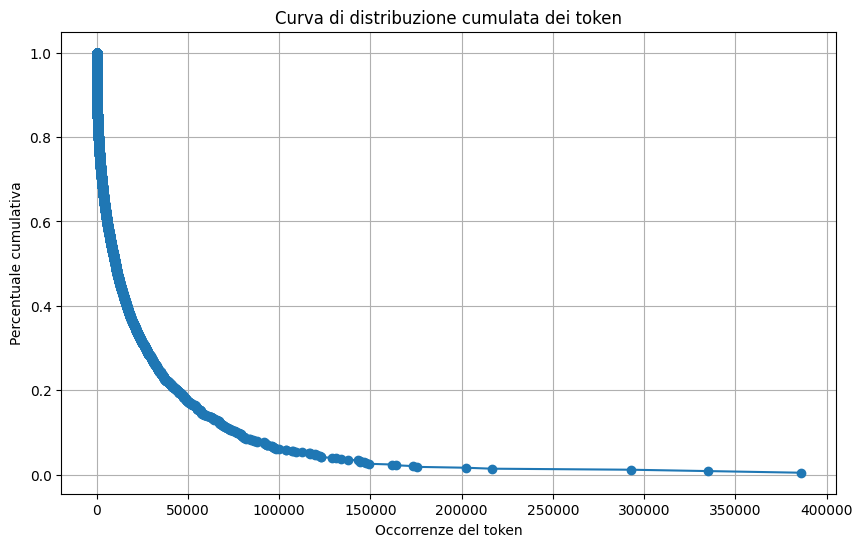

In [0]:
cumulative_distribution_pd = cumulative_distribution.toPandas()

# Rappresentazione della curva di distribuzione cumulativa
plt.figure(figsize=(10, 6))
plt.plot(cumulative_distribution_pd["frequency"].values, 
         cumulative_distribution_pd["cumulative_percentage"].values, marker="o")
plt.xlabel("Occorrenze del token")
plt.ylabel("Percentuale cumulativa")
plt.title("Curva di distribuzione cumulata dei token")
plt.grid()
plt.show()

Vista la distribuzione della curva cumulata, si potrebbe cercare di passare al modello solo i token che coprono fino all'80% delle occorrenze complessive del dataset, per ottenere una riduzione dello stesso e delle tempistiche di addestramento dei modelli.

In [0]:
#definizione di una soglia di copertura cumulativa
threshold_percentage = 0.80 

In [0]:
#filtro dei token che rientrano nella soglia
filtered_tokens = cumulative_distribution.filter(col("cumulative_percentage") <= threshold_percentage)

In [0]:
filtered_tokens.show()

+----------+---------+--------------------+---------------------+
|single_tok|frequency|cumulative_frequency|cumulative_percentage|
+----------+---------+--------------------+---------------------+
|       one|   385936|              385936| 0.004367197658105872|
|       new|   335110|              721046| 0.008159255427290034|
|     first|   292788|             1013834| 0.011472403379078677|
|     party|   216583|             1230417| 0.013923226236717105|
|       two|   202240|             1432657| 0.016211745717603396|
|  aircraft|   175763|             1608420|  0.01820065517922828|
|university|   173113|             1781533| 0.020159577612449547|
|       air|   164196|             1945729|  0.02201759652405756|
|      time|   161873|             2107602|  0.02384932869340837|
|  national|   149123|             2256725| 0.025536783650628534|
|     power|   147896|             2404621| 0.027210354047904832|
|references|   146774|             2551395| 0.028871228050513637|
|   compan

## Sviluppo di un Classificatore Automatico

Di seguito si riportano i passaggi per realizzare un classificatore automatico, quindi un modello di ML che sia in grado di classificare il testo di un articolo in una delle categorie del dataset.
Il modello verrà scelto svolgendo un addestramento sia sulla colonna summary che sulla colonna documents del dataset.

### Definizione della catena di Pre-Processing

Visti gli esiti dell'analisi EDA, per la costruzione della catena di pre-processing del dataset ed addestramento del modello si adotteranno i seguenti passaggi:
- eliminazione dei missing;
- tokenizzazione dei campi contenenti il testo su cui va addestrato il modello;
- eliminazione delle stop words ed i caratteri speciali;
- riduzione del numero di token da vettorizzare, mediante l'istanza del _CumulativeFrequencyFilter_;
- trattandosi di un problema di classificazione, sarà necessario realizzare un Encoding della variabile categorica utilizzando uno _StringIndexer_
- utilizzo del CountVctorizer per contare le occorrenze dei token;

Al termine del processing si passerà ad eseguire all'addestramento e valutazione del modello di classificazione: in prima istanza si procederà ad utilizzare un modello di regressione logistica, a seconda dei risultati poi verrà eventualmente valutata l'applicazione di un altro modello.

Al fine di introdurre nella pipeline di preprocessing lo step di eliminazione delle righe in cui il valore di "_documents_" è mancante, è necessario realizzare un trasformatore ad hoc da utilizzare poi nella pipeline.

In [0]:
class DropNullTransformer(Transformer):
    def __init__(self, inputCols=None):
        super(DropNullTransformer, self).__init__()
        self.inputCols = Param(self, "inputCols", "Columns to drop nulls from")
        self._setDefault(inputCols=[])

        if inputCols is not None:
            self._set(inputCols=inputCols)

    def setInputCols(self, value):
        self._set(inputCols=value)
        return self

    def getInputCols(self):
        return self.getOrDefault(self.inputCols)

    def _transform(self, dataset: DataFrame) -> DataFrame:
        cols = self.getInputCols()
        if not isinstance(cols, list) or not all(isinstance(col, str) for col in cols):
            raise ValueError("inputCols must be a list of strings")
        return dataset.dropna(subset=cols)

Inoltre, si definisce un trasformatore necessario ad introdurre in una pipeline di preprocessing il processo di filtraggio dei token, sulla base dell'aliquota di occorrenze complessive che si vogliono analizzare.

In [0]:
#definizione di un transformer per includere il filtraggio dei token nel preprocessing del dataset
class CumulativeFrequencyFilter(Transformer):
    def __init__(self, inputCol="tokens", outputCol="filtered_tokens", cumulative_threshold=0.9):
        super(CumulativeFrequencyFilter, self).__init__()
        self.inputCol = inputCol
        self.outputCol = outputCol
        self.cumulative_threshold = cumulative_threshold

    def _transform(self, dataset):
        # Esplosione dei token dalla colonna di input
        exploded_df = dataset.select(F.explode(self.inputCol).alias("single_tok"))
        
        # Calcolo delle frequenze
        token_counts = exploded_df.groupBy("single_tok").agg(F.count("*").alias("frequency"))
        
        # Calcolo della frequenza cumulata e percentuale
        total_tokens = token_counts.agg(F.sum("frequency").alias("total_count")).collect()[0]["total_count"]
        token_counts = token_counts.withColumn("cumulative_frequency", 
                                               F.sum("frequency").over(Window.orderBy(F.desc("frequency"))))
        token_counts = token_counts.withColumn("cumulative_percentage", 
                                               token_counts["cumulative_frequency"] / lit(total_tokens))
        
        # filtro dei token basati sulla soglia di percentuale cumulata
        valid_tokens = token_counts.filter(col("cumulative_percentage") <= self.cumulative_threshold) \
                                   .select("single_tok")
        
        # Colleziona i token validi in un set
        valid_tokens_set = {row["single_tok"] for row in valid_tokens.collect()}
        
        # Funzione UDF per applicare il filtro sui token
        def filter_tokens(tokens):
            return [token for token in tokens if token in valid_tokens_set]
        
        filter_tokens_udf = F.udf(filter_tokens, ArrayType(StringType()))
        
        # Restituisce il dataframe con la nuova colonna dei token filtrati
        return dataset.withColumn(self.outputCol, filter_tokens_udf(col(self.inputCol)))

### Utilizzo del contenuto degli articoli come feature

In [0]:
#definizione dell'istanza dell'imputer custom
imputer = DropNullTransformer(inputCols = ['documents'])

In [0]:
#definizione dell'istanza del tokenizer
token = Tokenizer(inputCol='documents', outputCol='tokens')

In [0]:
#definizione dei trasformatori per l'eliminazione delle stopwords e caratteri speciali
sc_remover = SpecialCharRemover(inputCol='tokens', outputCol='no_sc_tokens')
sw_remover = StopWordsRemover(inputCol='no_sc_tokens', outputCol='cleaned_tokens', stopWords=custom_stop_words)

In [0]:
#inizializzazione del filtro dei token
tok_filter = CumulativeFrequencyFilter(inputCol='cleaned_tokens', outputCol='filtered_tokens', cumulative_threshold=0.8)

In [0]:
#inizializzazione del count vectorizer
vectorizer = CountVectorizer(inputCol='filtered_tokens', outputCol='features')

In [0]:
#inizializzazione dell'indexer per la definizione degli indici numerici delle categorie della variabile target
indexer = StringIndexer(inputCol='categoria', outputCol='categoria_index')

In [0]:
#realizzazione della pipeline di pre-processing da applicare al dataset
pp_pipeline = Pipeline(stages=[imputer, token, sc_remover, sw_remover, tok_filter, vectorizer, indexer])

In [0]:
#divisione del dataset in training e test
train, test = df.randomSplit([0.8, 0.2])

In [0]:
#si addestra la pipeline con il dataset di training
pp_model = pp_pipeline.fit(train)

In [0]:
#applicazione del pre-processing sul dataset di train
pp_train = pp_model.transform(train)

In [0]:
#definizione del modello di regressione logistica
lr = LogisticRegression(featuresCol='features', labelCol='categoria_index')

In [0]:
#addestramento del modello sul dataset di train
model = lr.fit(pp_train)

In [0]:
#applicazione del pre-processing al dataset di test
pp_test = pp_model.transform(test)

In [0]:
#si applica la trasformazione al dataset di test
prediction = model.transform(pp_test)

In [0]:
#definizione dell'evaluator che consente di determinare le prestazioni del modello
evaluator = MulticlassClassificationEvaluator(labelCol='categoria_index', predictionCol='prediction', metricName='accuracy')
evaluator.evaluate(prediction)

0.930528728106073

Quindi l'accuratezza del modello è del 93%, quindi un valore abbastanza elevato considerando anche la riduzione del numero di token presi in esame.

#### Confronto con modello di Naive Bayes

Si confrontano i risultati ottenuti provando ad applicare un modello di Naive Bayes, che ottiene delle buone performance in questi contesti.
Il modello verrà applicato al dataset già pretrattato che è stato usato per addestrare il modello di regressione logistica. Gli step preliminari dei due modelli coincidono abbastanza.

In [0]:
nb = NaiveBayes(featuresCol='features', labelCol='categoria_index')

In [0]:
#addestramento sul dataset pretrattato
nb_model = nb.fit(pp_train)

In [0]:
#applicazione del modello al dataset di test
prediction_2 = nb_model.transform(pp_test)

In [0]:
#definizione dell'evaluator che consente di determinare le prestazioni del modello
evaluator_2 = MulticlassClassificationEvaluator(labelCol='categoria_index', predictionCol='prediction', metricName='accuracy')
evaluator_2.evaluate(prediction_2)

0.8491733507939107

Quindi si può vedere come il modello di Navie Bayes offra un'accuratezza inferiore rispetto alla regressione logistica.

### Utilizzo del sommario degli articoli come feature

In [0]:
#definizione dell'istanza dell'imputer custom
imputer_2 = DropNullTransformer(inputCols = ['summary'])

In [0]:
#definizione dell'istanza del tokenizer
token_2 = Tokenizer(inputCol='summary', outputCol='tokens')

In [0]:
#definizione dei trasformatori per l'eliminazione delle stopwords e caratteri speciali
sc_remover_2 = SpecialCharRemover(inputCol='tokens', outputCol='no_sc_tokens')
sw_remover_2 = StopWordsRemover(inputCol='no_sc_tokens', outputCol='cleaned_tokens', stopWords=custom_stop_words)
#inizializzazione del filtro dei token
tok_filter_2 = CumulativeFrequencyFilter(inputCol='cleaned_tokens', outputCol='filtered_tokens', cumulative_threshold=0.8)
#inizializzazione del count vectorizer
vectorizer_2 = CountVectorizer(inputCol='filtered_tokens', outputCol='features')
#inizializzazione dell'indexer per la definizione degli indici numerici delle categorie della variabile target
indexer_2 = StringIndexer(inputCol='categoria', outputCol='categoria_index')

In [0]:
#definizione della pipeline
pp_pipeline_2 = Pipeline(stages=[imputer_2, token_2, sc_remover_2, sw_remover_2, tok_filter_2, vectorizer_2, indexer_2])

In [0]:
#addestramento del preprocessing sul dataset di train
pp_model_2 = pp_pipeline_2.fit(train)

In [0]:
#applicazione delle trasformazioni al dataset di train
pp_train_2 = pp_model_2.transform(train)

In [0]:
#definizione del modello di regressione logistica
lr_2 = LogisticRegression(featuresCol='features', labelCol='categoria_index')

In [0]:
#addestramento del modello sul dataset di train
model_2 = lr_2.fit(pp_train_2)

In [0]:
#applicazione del pre-processing al dataset di test
pp_test_2 = pp_model_2.transform(test)

In [0]:
#si applica la trasformazione al dataset di test
prediction_3 = model_2.transform(pp_test_2)

In [0]:
#definizione dell'evaluator che consente di determinare le prestazioni del modello
evaluator_3 = MulticlassClassificationEvaluator(labelCol='categoria_index', predictionCol='prediction', metricName='accuracy')
evaluator_3.evaluate(prediction_3)

0.9131118022589622

Anche in questo caso si ottiene un buon livello di accuratezza, anche se leggermente inferiore al caso di utilizzo del testo completo degli articoli.

#### Confronto con modello di Naive Bayes

Si confrontano i risultati ottenuti provando ad applicare un modello di Naive Bayes, che ottiene delle buone performance in questi contesti.
Il modello verrà applicato al dataset già pretrattato che è stato usato per addestrare il modello di regressione logistica. Gli step preliminari dei due modelli coincidono abbastanza.

In [0]:
#inizializzazione dell'istanza del modello
nb_2 = NaiveBayes(featuresCol='features', labelCol='categoria_index')

In [0]:
#addestramento sul dataset pretrattato
nb_model_2 = nb_2.fit(pp_train_2)

In [0]:
#applicazione del modello al dataset di test
prediction_4 = nb_model_2.transform(pp_test_2)

In [0]:
#definizione dell'evaluator che consente di determinare le prestazioni del modello
evaluator_4 = MulticlassClassificationEvaluator(labelCol='categoria_index', predictionCol='prediction', metricName='accuracy')
evaluator_4.evaluate(prediction_4)

0.8612538877066623

Quindi si può vedere come il modello di Navie Bayes offra un'accuratezza inferiore rispetto alla regressione logistica anche nel caso di applicazione al sommario degli articoli.

## Considerazioni finali
La definizione del classificatore automatico ha richiesto un'intesa fase di analisi esplorativa, necessaria per definire le caratteristiche principali del dataset a disposizione.
L'evidenza principale è stata che il numero di token presenti nel dataset è molto esteso (quasi 90 milioni di token): a questo proposito quindi si è cercato di capire se una riduzione del numero di token da considerare poteva beneficiare sulle prestazioni e l'accuratezza del modello.
Considerando solo i token che contrubuivano per l'80% della distribuzione cumulata delle occorrenze di tutto il dataset, si è visto che con un modello di regressione logistica si è raggiunta un'accuratezza del __93%__ nella classificazione degli articoli nelle diverse categorie del dataset, sfruttando il testo completo degli stessi.
Utilizzando poi come campo di riferimento, il sommario degli articoli, si è visto che l'accuratezza raggiunta è stata del __91%__ circa: questo da un lato può sicuramente dipendere dalla minore numerosità dei token ottenuti dal campo _"summary"_ rispetto al campo _"documents"_, ma anche dal fatto che avendo applicato lo stesso preprocessing al dataset la soglia per filtrare i token è stata lasciata del 80% e forse questo potrebbe aver penalizzato maggiormente tale analisi. D'altra parte, però, c'è da dire che le tempistiche di esecuzione del pre-processing e di addestramento del modello di regressione logistica, sono molto migliori nel caso di utilizzo del campo summary, a discapito di un paio di punti percentuali sull'accuratezza. Quindi poi a seconda delle esigenze, è possibile scegliere la soluzione più adatta.

Infine, si ricorda che è stato eseguito un confronto sul tipo di modello da utilizzare, confrontando le prestazioni della regressione logistica con un modello di __Navie Bayes__: si è visto che con la regressione logistica si ottengono prestazioni migliori, anche se è doveroso sottolineare come sia nel caso del testo completo degli articoli (_documents_), che nel caso del sommario (_summary_), il tempo di addestramento del modello di Naive Bayes è molto inferiore.